In [1]:
"""
OBJETIVO : Seleccionar una muestra de datos para el entrenamiento. Este proceso se realiza por cada 
            modelo (Regresion y clasifiacion). Ademas, se realiza una limpieza de datos, y se divide
            el DS para lso modelos de clasifiacion, para asi balancear las calses.
TERMINOS:
- REG = Regresion
- CLAS = Clasifiacion
- EST = Seleccion por Estaciones
- DUD = Solo datos dusosos en flag V2
            
"""
Autor='Diego Paredes'

In [2]:
# Leer imagenes satelitales (.nc) 
from netCDF4 import Dataset, num2date

# Graficos y visualizaciones
import cartopy.crs as ccrs
import cartopy.feature as cfw
import matplotlib.pyplot as plt

# Liberias para manejo de datos
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Liberias estandar
import re
import time
import os

In [3]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes'

In [28]:
"""
Variables generales
"""
path_imagenes = 'F:/GOES/' 

dsName = 'dsCompletoPP_V2'
listDataset = [f'{path_base}/Archivos/Inicial/{dsName}.csv']           

#Variables generales
products = ['C07','C08','C13']
times   = ['10','20','30','40','50','00']


In [33]:
# Filtra por flags (V1, V2)
def limpiarDatos(listNames, path_imagenes, p, read=True):    
    df = []
    start_time = time.time()
    print(f'Se leera los archivos de datasets...')
    if read:
        for name in listNames:
            try:
                df.append(pd.read_csv(name))   
            except:
                print(f'No se pudo leer el archivo {name} de dataset')
                return -1

        if len(df)>1:
            dsCompleto =  pd.concat(df, ignore_index=True) 
        else:
            dsCompleto =  df[0]
    else:
        dsCompleto = listNames
        
        
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos leidos {len(dsCompleto)}')
    
    # Quitamos los NA valores, negativos y mayores a 400
    print(f'\nSe elimnara los valores nulos y dudosos')
    dsCompleto.dropna(subset=['dato'], axis='index', inplace=True)    
    dsCompleto = dsCompleto[dsCompleto['flag']!='ND']
    dsCompleto = dsCompleto[dsCompleto['dato']>=0]
    dsCompleto = dsCompleto[dsCompleto['dato']<400]
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos luego de elimnar nulos {len(dsCompleto)}')
              
    
    # Seleccionamos FLAGS
    if p['flags']:
        dsCompleto = dsCompleto[dsCompleto['flag'].isin(p['flags'])]    
    if p['flagV2']:
        dsCompleto = dsCompleto[dsCompleto['flagV2'].isin(p['flagV2'])]                   
                             
    print(f'-------> CANTIDAD FINAL DE DATOS :  {len(dsCompleto)} <--------------')  
    print("Tiempo total: %.2fs" % (time.time() - start_time))
    return shuffle(dsCompleto)

In [34]:
# Separa el df en tres grupos (0, entre 0 y 1, mayor a 1) y luego escoje un porcentaje (porc) de cada uno
def getBalancedDataset(df,porc):
    listP = []
    listT = []    
    
    df0 = df[df['dato']==0]
    df01 = df[(df['dato']>0) & (df['dato']<=1)]
    df1 = df[df['dato']>1]
    
    if not df0.empty:
        dsT0, dsP0 = train_test_split(df0, test_size=porc, shuffle=True)  
        listT.append(dsT0)
        listP.append(dsP0)        
        
    if not df01.empty:
        dsT1,dsP1 = train_test_split(df01, test_size=porc, shuffle=True)
        listT.append(dsT1)
        listP.append(dsP1)
        
    if not df1.empty:
        dsT_, dsP_ =  train_test_split(df1, test_size=porc, shuffle=True)
        listT.append(dsT_)
        listP.append(dsP_)
    
   
    dfTrain = pd.concat(listT, ignore_index=True) 
    dfPrueba = pd.concat(listP, ignore_index=True)
    return dfTrain, dfPrueba    

In [35]:
# Escoje un grupo balanceado de un df 
def obtenerDSPruebas(df, porc, tipo='Clasificacion'):
    """
    Separamos el dataset en 3 partes, y se ecoje un porcentaje de los tres
    - Datos : 0
    - Dato  : < 0,1 ]
    - Dato  : <1 , --]
    """
    
    if tipo=='Clasificacion':
        dfC02 = df[df['flag']=='C0000002'] 
        dfM02 = df[df['flag']=='M0000002']
    
        C02T,C02P = getBalancedDataset(dfC02,porc)
        M02T,M02P = getBalancedDataset(dfM02,porc)   
    
   
        dfTrain = pd.concat([C02T,M02T], ignore_index=True) 
        dfPrueba = pd.concat([C02P,M02P], ignore_index=True) 
        
        return dfTrain, dfPrueba
        
    else:        
        return getBalancedDataset(df,porc)
    
    return -1

In [36]:
# Se para un dataset (listNames) en pruebas, validacion y entrenamiento
def getModelo_DS(listNames, path_imagenes, p,comentario='', read=True):
    print(f'Tipo de dataset: {p["redTipo"]}')
    # Limpiamos en dataset
    dfLimpio = limpiarDatos(listNames, path_imagenes, p, read)    
    #dfLimpio = pd.read_csv(listNames[0])
    dfLimpio.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/{p["nameDS"]}_CompletoDS.csv')
    
    if p['estaciones']:
        print(f'Se limitara el DS a {len(p["estaciones"])} estaciones')
        dfLimpio = dfLimpio[dfLimpio['codigo'].isin(p['estaciones'])]
    
    if p['redTipo'] == 'Clasificacion':
        dfLimpio[p['claseName']] = (dfLimpio[p['condicion_1'][0]]==p['condicion_1'][1]).astype(int)       
        
    
    # Separamos los datasets (entrenamiento, validacion y test)
    _dsTrain, _dsTest = obtenerDSPruebas(dfLimpio, p['pruebas'], tipo=p['redTipo']) 
    _dsTrain, _dsValid = obtenerDSPruebas(_dsTrain, p['validacion'], tipo =p['redTipo'])
    
    # Guardamos los archivos    
    _dsTest.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Pruebas/{p["nameDS"]}_PruebasDS.csv')
    _dsValid.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Validacion/{p["nameDS"]}_ValidacionDS.csv')
    _dsTrain.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Entrenamiento/{p["nameDS"]}_TrainDS.csv')
    
    print('Tamaño de los datasets: ')
    print(f'TRAIN   : {len(_dsTrain)}')
    print(f'VALID   : {len(_dsValid)}')
    print(f'PRUEBAS : {len(_dsTest)}')

    # Guardamos el comentario (Informacion de lso datasets)

    with open(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/{p["nameDS"]}_comentario.txt', 'w') as file:
        file.write(f'Archivos iniciales que se uso : {str(listNames)}\n')
        file.write(comentario)
        file.write(' A continuacion se muestra los parametros que se usaron:\n')        
        file.write(str(p))
    statsDS(dfLimpio, p['nameDS'], tipo=p["redTipo"])
    visualizarEstaciones(dfLimpio, name = p['nameDS'],imagenTest='')
    return dfLimpio

In [37]:
# Grafica las estaciones meteorologicas del df en un mapa del Perú.
def visualizarEstaciones(df, name = '',imagenTest='', xCode=True, row='codigo'):
    if not imagenTest:
        imagenTest = 'F:/GOES/C08/2021/01/G16_C08_Cyl_20210101-0020.nc'
    
    ds = Dataset(imagenTest)
    field = ds.variables['CMI'][:].data.astype(np.float32)/100.0

    # obtiene las coordenadas de los pixeles
    lons = ds.variables['longitude'][:].data
    lats = ds.variables['latitude'][:].data
    #lons, lats = np.meshgrid(lons, lats)
    
    Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'
    dfEstaciones = pd.read_csv(Festaciones)
    dfCod = df[row].unique()
    dfCod = pd.DataFrame({row:dfCod.tolist()})

    #Graficomos las estaciones para el ds de regresion
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.title(f'{name} - Peru ({len(dfCod)} estaciones)')
    ax.set_extent([lons.min(), lons.max(), lats.min(),lats.max()], ccrs.PlateCarree())

    for x in dfCod.index:
        if xCode:
            st = dfEstaciones[dfEstaciones['CODE'] == f'X{dfCod[row][x]}']
        else:
            st = dfEstaciones[dfEstaciones['CODE'] == f'{dfCod[row][x]}']    
        if not st.empty:    
            x = st['LON']#.iloc[0]
            y = st['LAT']#.iloc[0]
            plt.plot(x, y,  1, marker='o', color='red',alpha=0.45)    

    ax.coastlines(resolution='110m')
    
    plt.savefig(f'{path_base}/Archivos/Reportes/Plots/MAPA_{name}.png')
    plt.show()

In [38]:
# Estadisticas de un df
def statsDS(df, name='ds', tipo='Clasificacion'):    
    print(f'           ESTADISCIAS DEL {name} \n')  
    print(f'Flags       : {df["flag"].unique()}')
    print(f'Estaciones  : {len(df["codigo"].unique())}')
    print(f'Totales     : {df["dato"].count()}')
    print(f'Ceros       : {df[df["dato"]==0]["dato"].count()}')    
    if tipo=='Regresion':
        print(f'Menor a 1   : {df[df["dato"]<1]["dato"].count()}')
        print(f'Mayor a 1   : {df[df["dato"]>1]["dato"].count()}')
    else:
        print(f'Clase 0(M02): {df[df["flag"]=="M0000002"]["dato"].count()}')
        print(f'Clase 1(C02): {df[df["flag"]=="C0000002"]["dato"].count()}')
    print(f'Maximo      : {df["dato"].max()}')
    print(f'Media       : {df["dato"].mean()}')
    print(f'STD         : {df["dato"].std()}')

    #_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)
    #_dataset[_dataset["dato"]>1]["dato"].hist(legend=True)
    if tipo=='Clasificacion':
        df['flag'].hist(legend=True)
        plt.xlabel('FLAG')
        plt.ylabel('Cantidad')
        plt.title('Histograma de FLAG')
    else:
        df['dato'].hist(legend=True)   
        plt.xlabel('Valor')
        plt.ylabel('Cantidad')
        plt.title('Histograma de Precipitacion')
    plt.show()

In [39]:
"""
Clasificacion
"""
comentarioCLAS = 'El dataset es para lso modelos de clasificaicon, se usa como clase 1 los datos con flag = C02\
               y todos los flags M02 como clase 0.\n- V2: V2 del joinDataset'
p_clas = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset
    'ceros'      : 0.10,   
    'flags'      : ['C0000002','M0000002'],
    'flagV2'     : ['D01','D02','C01'],    
    'estaciones' : [],
    'delete'     : True,
    
    # Split
    'pruebas'    : 0.01,
    'validacion' : 0.1,
    
    # Modelo
    'redTipo'    : 'Clasificacion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : 'clase',
    'condicion_1': ['flag','C0000002'],    
    
    # Nombres
    'nameDS'     : 'ClaseV2',       
}

Tipo de dataset: Clasificacion
Se leera los archivos de datasets...
Tiempo tomado: 0.09s
+Cantidad de datos leidos 50084

Se elimnara los valores nulos y dudosos
Tiempo tomado: 0.11s
+Cantidad de datos luego de elimnar nulos 50084
-------> CANTIDAD FINAL DE DATOS :  43270 <--------------
Tiempo total: 0.12s
Tamaño de los datasets: 
TRAIN   : 38548
VALID   : 4287
PRUEBAS : 435
           ESTADISCIAS DEL ClaseV2 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 153
Totales     : 43270
Ceros       : 9560
Clase 0(M02): 2802
Clase 1(C02): 40468
Maximo      : 337.5
Media       : 1.4587111162468223
STD         : 7.199059693367714


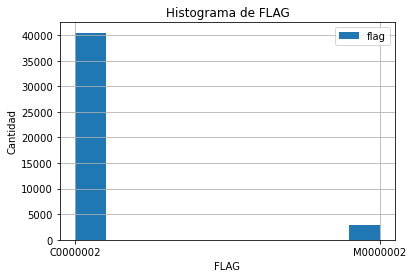

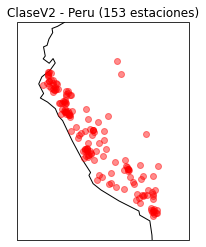

,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,umb1,umb2,fecha,flag,flagV2,imagen,clase
35455,TUNEL CHOTANO,47E1F02E,265,440,-78.78432,-6.54049,2027.0,1.6,0.1,3.976,0.0,0.5,4.0,2021-10-18-17,C0000002,D02,265--440--2021-10-18-17,1
2948,PUENTE CARRETERA,47251282,759,923,-69.87381,-15.25544,3812.0,2.3,0.0,1.100,0.0,2.6,6.4,2021-04-05-00,C0000002,D02,759--923--2021-04-05-00,1


In [40]:
dfLimpioCLAS = getModelo_DS(listDataset, path_imagenes, p_clas,comentario=comentarioCLAS)
dfLimpioCLAS.head(2)

In [41]:
"""
Regresion
"""
comentarioREG = 'El dataset es para lso modelos de regresion, se usa como output el dato \
            Se ha realizado una limpieza de datos (quitado datos malos 1 y verificado que exista \
            las imagenes satelitales). Ademas se ha validado con el flagV2 los datos erroneos V2: Juntar archivos y Analisis V2'

p_reg = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset
    'ceros'      : 0.10,   
    'flags'      : ['C0000002'],
    'flagV2'     : ['D01','D02','C01'],   
    'estaciones' : [],
    'delete'     : True,
    
    # Split
    'pruebas'    : 0.01,
    'validacion' : 0.2,
    
    # Modelo
    'redTipo'    : 'Regresion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : '',
    'condicion_1': [],    
    
    # Nombres
    'nameDS'     : 'REGV2',       
}

Tipo de dataset: Regresion
Se leera los archivos de datasets...
Tiempo tomado: 0.14s
+Cantidad de datos leidos 50084

Se elimnara los valores nulos y dudosos
Tiempo tomado: 0.17s
+Cantidad de datos luego de elimnar nulos 50084
-------> CANTIDAD FINAL DE DATOS :  40468 <--------------
Tiempo total: 0.19s
Tamaño de los datasets: 
TRAIN   : 32048
VALID   : 8014
PRUEBAS : 406
           ESTADISCIAS DEL REGV2 

Flags       : ['C0000002']
Estaciones  : 152
Totales     : 40468
Ceros       : 7498
Clase 0(M02): 0
Clase 1(C02): 40468
Maximo      : 66.9
Media       : 1.3654349115350402
STD         : 2.95607456796997


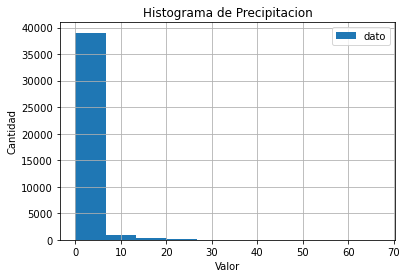

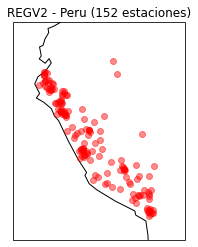

,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,umb1,umb2,fecha,flag,flagV2,imagen
18081,CUMBA,472B3006,271,406,-78.66413,-5.94135,449.0,0.1,0.0,2.557,0.0,0.5,7.3,2021-10-06-02,C0000002,D01,271--406--2021-10-06-02
46048,INTIHUATANA M,472852EE,610,811,-72.56050,-13.22431,1780.0,1.8,0.2,4.400,0.0,1.6,3.7,2021-02-16-02,C0000002,D01,610--811--2021-02-16-02


In [42]:
dfLimpioREG = getModelo_DS(listDataset, path_imagenes, p_reg ,comentario=comentarioREG)
dfLimpioREG.head(2)

In [ ]:
"""
Escojemos las mejores estaciones (por cantidad de datos conformes, estadisticas , etc)
"""

In [43]:
# Archivo de analisis
analisisTotal = f'{path_base}/Archivos/Reportes/Datos/analisis_Total.csv'
dfAnaTotal = pd.read_csv(analisisTotal)
dfAnaTotal.head(2)

,count,mean,std,min,25%,50%,75%,max,FechaMax,FechaMin,...,cantM02,cantD01,75mayor,90mayor,90%,99mayor,99%,LON,LAT,ALT
0,15298,0.045169,1.962420,0.0,0.0,0.0,0.0,234.0,31/12/2021,01/01/2021,...,0,79,330,330,0.0,144,0.3,-80.39788,-4.48047,116.0
1,9123,0.046092,0.664392,0.0,0.0,0.0,0.0,36.0,31/12/2021,01/01/2021,...,0,123,240,240,0.0,90,0.6,-80.39014,-4.48956,116.0


In [44]:
bestMean = 30
bestConf = 20

dfMejor = dfAnaTotal.sort_values('mean',ascending=False).head(bestMean)
dfMejor['POR_NO_C01'] = 1 - dfAnaTotal['cantC01'] / dfAnaTotal['count']
dfMejor = dfMejor.sort_values(['cantM01','POR_NO_C01'], ascending=True).head(bestConf)[['Codigo','count','POR_NO_C01','mean','cantM01','cantM02','cantC01','cantC02','cantD01']]

dfMejor.head(2)

,Codigo,count,POR_NO_C01,mean,cantM01,cantM02,cantC01,cantC02,cantD01
134,X47E86310,4277,0.058920,0.211083,0,0,4025,139,113
189,X109093,7516,0.063465,0.247006,0,0,7039,240,237


In [45]:
dfGraficar = dfMejor[0:19]

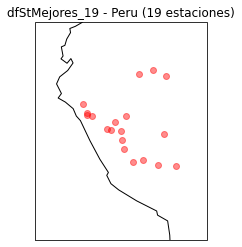

In [46]:
visualizarEstaciones(dfGraficar, name = 'dfStMejores_19', xCode = False, row='Codigo')

In [47]:
"""
Regresion
"""
comentarioREG_EST = 'El dataset es para lso modelos de regresion, se usa como output el dato \
            Se ha realizado una limpieza de datos (quitado datos malos 1 y verificado que exista \
            las imagenes satelitales). ADICIONALMENTE, se esta limitando los datos a estaciones especificas,\
            las cuales fueron escogidas luego del analisis- V2: Juntar archivos y Analisis V2'

p_reg_est = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset
    'ceros'      : 0.8,   
    'flags'      : ['C0000002'],
    'flagV2'     : ['D01','D02','C01'],
    'estaciones' : [x[1:] for x in dfGraficar['Codigo'].unique().tolist()],
    'delete'     : True,
    
    # Split
    'pruebas'    : 0.01,
    'validacion' : 0.2,
    
    # Modelo
    'redTipo'    : 'Regresion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : '',
    'condicion_1': [],    
    
    # Nombres
    'nameDS'     : 'Dato_EST_V2',       
}

In [ ]:
(venv) C:\DeployModelos> pip install -r requirements.txt

In [ ]:
(venv) C:\DeployModelos> python Deploy.py

Tipo de dataset: Regresion
Se leera los archivos de datasets...
Tiempo tomado: 0.08s
+Cantidad de datos leidos 50084

Se elimnara los valores nulos y dudosos
Tiempo tomado: 0.10s
+Cantidad de datos luego de elimnar nulos 50084
-------> CANTIDAD FINAL DE DATOS :  40468 <--------------
Tiempo total: 0.11s
Se limitara el DS a 19 estaciones
Tamaño de los datasets: 
TRAIN   : 3873
VALID   : 970
PRUEBAS : 50
           ESTADISCIAS DEL Dato_EST_V2 

Flags       : ['C0000002']
Estaciones  : 16
Totales     : 4893
Ceros       : 535
Clase 0(M02): 0
Clase 1(C02): 4893
Maximo      : 66.9
Media       : 3.0920498671571632
STD         : 5.40526946682217


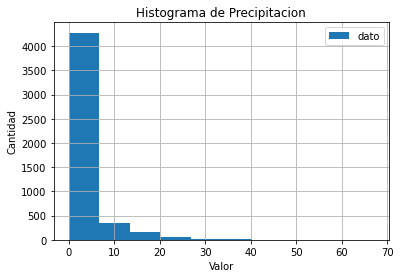

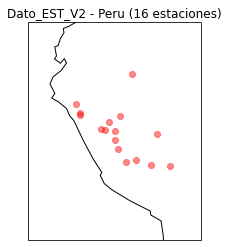

,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,umb1,umb2,fecha,flag,flagV2,imagen
22571,PUERTO INCA,4727A4F8,477,597,-74.96083,-9.38139,253.0,2.1,0.0,7.5,0.0,1.1,7.4,2021-12-20-14,C0000002,D02,477--597--2021-12-20-14
36023,CACHICOTO,47E845FC,400,586,-76.35028,-9.18361,1109.0,5.2,0.2,8.4,0.0,5.5,28.6,2021-10-17-10,C0000002,D02,400--586--2021-10-17-10


In [48]:
dfLimpioREG_EST = getModelo_DS(listDataset, path_imagenes, p_reg_est ,comentario=comentarioREG_EST)
dfLimpioREG_EST.head(2)

In [49]:
"""
Clasificacion
"""
comentarioCLAS_DUD = 'El dataset es para lso modelos de clasificaicon, se usa como clase 1 los datos con flag = C02\
               y todos los flags M02 como clase 0.\n- V2: V2 del joinDataset - DUD: Solo se escoje los dudsoso flag v2'
p_clas_dud = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset  
    'flags'      : ['C0000002','M0000002'],
    'flagV2'     : ['D01','D02'],
    'estaciones' : [],
    'delete'     : True,
    
    # Split
    'pruebas'    : 0.01,
    'validacion' : 0.1,
    
    # Modelo
    'redTipo'    : 'Clasificacion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : 'clase',
    'condicion_1': ['flag','C0000002'],    
    
    # Nombres
    'nameDS'     : 'ClaseV2_DUD',       
}

Tipo de dataset: Clasificacion
Se leera los archivos de datasets...
Tiempo tomado: 0.08s
+Cantidad de datos leidos 50084

Se elimnara los valores nulos y dudosos
Tiempo tomado: 0.10s
+Cantidad de datos luego de elimnar nulos 50084
-------> CANTIDAD FINAL DE DATOS :  32376 <--------------
Tiempo total: 0.11s
Tamaño de los datasets: 
TRAIN   : 28843
VALID   : 3207
PRUEBAS : 326
           ESTADISCIAS DEL ClaseV2_DUD 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 153
Totales     : 32376
Ceros       : 0
Clase 0(M02): 496
Clase 1(C02): 31880
Maximo      : 337.5
Media       : 1.9300756733382753
STD         : 8.268104718866944


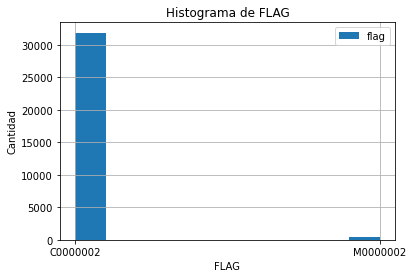

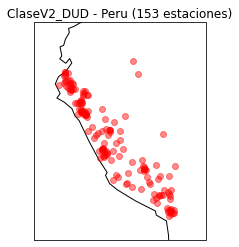

,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,umb1,umb2,fecha,flag,flagV2,imagen,clase
15864,NARANJITO,220907,293,400,-78.27598,-5.81968,500.0,0.4,0.0,2.0,0.0,0.6,11.8,2021-12-07-15,C0000002,D01,293--400--2021-12-07-15,1
549,CHALACO,472FB328,206,356,-79.83000,-5.03389,1791.0,0.3,0.1,2.4,0.0,4.9,9.0,2021-06-20-10,C0000002,D02,206--356--2021-06-20-10,1


In [50]:
dfLimpioCLAS_DUD = getModelo_DS(listDataset, path_imagenes, p_clas_dud ,comentario=comentarioCLAS_DUD)
dfLimpioCLAS_DUD.head(2)

In [ ]:
"""
----------------------------TEMPORAL (Se analiza los datasets con mas detalle)
"""

           ESTADISCIAS DEL ds_clas_M02 

Flags       : ['M0000002']
Estaciones  : 34
Totales     : 496
Ceros       : 0
Clase 0(M02): 496
Clase 1(C02): 0
Maximo      : 337.5
Media       : 15.780463709677422
STD         : 59.99939456248994


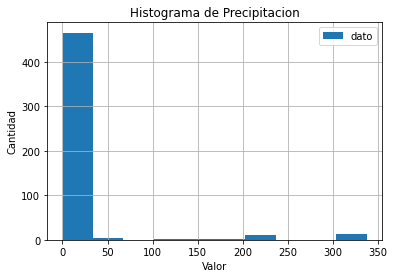

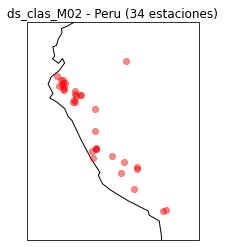

In [51]:
# Solo datos C02 de DUD
dfMALO02 = dfLimpioCLAS_DUD[dfLimpioCLAS_DUD['clase']==0]
statsDS(dfMALO02, name='ds_clas_M02', tipo='Regresion')
visualizarEstaciones(dfMALO02, name = 'ds_clas_M02',xCode=True, row='codigo')

           ESTADISCIAS DEL ds_clas_C02 

Flags       : ['C0000002']
Estaciones  : 152
Totales     : 31880
Ceros       : 0
Clase 0(M02): 0
Clase 1(C02): 31880
Maximo      : 66.9
Media       : 1.714586574654956
STD         : 3.2397999683384695


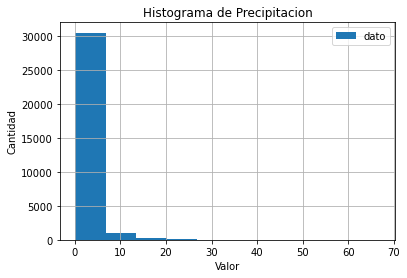

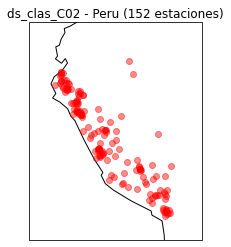

In [52]:
# Solo datos C02 de DUD
dfCONF02 = dfLimpioCLAS_DUD[dfLimpioCLAS_DUD['clase']==1]
statsDS(dfCONF02, name='ds_clas_C02', tipo='Regresion')
visualizarEstaciones(dfCONF02, name = 'ds_clas_C02',xCode=True, row='codigo')

           ESTADISCIAS DEL ds_clas_C02_10 

Flags       : ['C0000002']
Estaciones  : 64
Totales     : 793
Ceros       : 0
Clase 0(M02): 0
Clase 1(C02): 793
Maximo      : 66.9
Media       : 17.38298865069357
STD         : 7.86592836617139


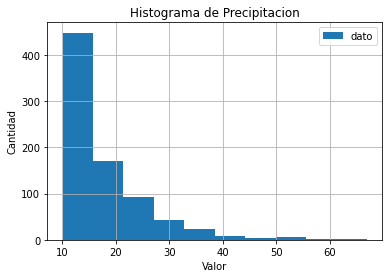

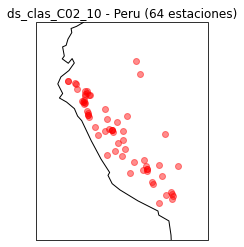

In [53]:
# Datos mayor a 10 de C02
dfCONF02_10 = dfCONF02[dfCONF02['dato']>10]
statsDS(dfCONF02_10, name='ds_clas_C02_10', tipo='Regresion')
visualizarEstaciones(dfCONF02_10, name = 'ds_clas_C02_10',xCode=True, row='codigo')

           ESTADISCIAS DEL ds_clas_C02_1m 

Flags       : ['C0000002']
Estaciones  : 150
Totales     : 18438
Ceros       : 0
Clase 0(M02): 0
Clase 1(C02): 18438
Maximo      : 0.9
Media       : 0.3522529558520447
STD         : 0.24814316258526162


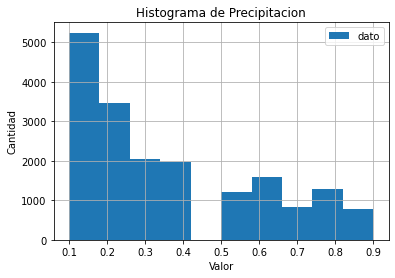

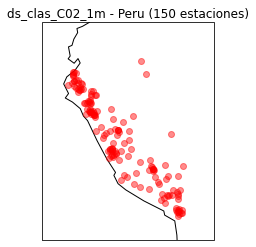

In [54]:
# Datos menor a 1 de C02
dfCONF02_1m = dfCONF02[dfCONF02['dato']<1]
statsDS(dfCONF02_1m, name='ds_clas_C02_1m', tipo='Regresion')
visualizarEstaciones(dfCONF02_1m, name = 'ds_clas_C02_1m',xCode=True, row='codigo')

           ESTADISCIAS DEL clas_val_dud 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 143
Totales     : 3207
Ceros       : 0
Clase 0(M02): 50
Clase 1(C02): 3157
Maximo      : 230.9
Media       : 1.8101465544122233
STD         : 5.181537002812556


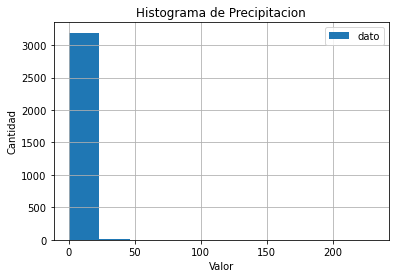

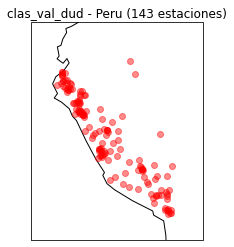

In [57]:
clas_val_dud = pd.read_csv(f'{path_base}/Archivos/Dataset/Clasificacion/Validacion/ClaseV2_DUD_ValidacionDS.csv')
statsDS(clas_val_dud, name='clas_val_dud', tipo='Regresion')
visualizarEstaciones(clas_val_dud, name = 'clas_val_dud',xCode=True, row='codigo')

           ESTADISCIAS DEL clas_val_dud 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 143
Totales     : 3207
Ceros       : 0
Clase 0(M02): 50
Clase 1(C02): 3157
Maximo      : 230.9
Media       : 1.8101465544122233
STD         : 5.181537002812556


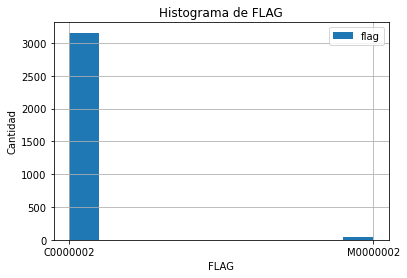

In [58]:
statsDS(clas_val_dud, name='clas_val_dud', tipo='Clasificacion')